<a href="https://colab.research.google.com/github/AdiY2j/CS6910_Assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


In [2]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
np.set_printoptions(suppress=True)
from keras.datasets import fashion_mnist

In [3]:
wandb.login(key='')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
X_train.shape[0]

60000

wandb: Currently logged in as: cs23m009. Use `wandb login --relogin` to force relogin


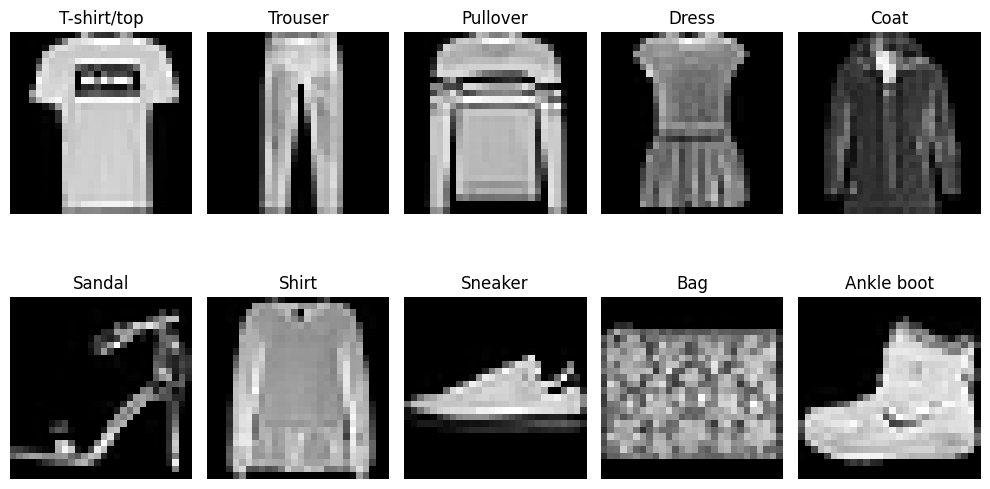

In [6]:
wandb.init(project = 'DL_Assignment_1', entity = 'cs23m009')
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

images = []
labels = []
# Function to plot one sample image for each class
def plot_data(x, y, class_labels):
    plt.figure(figsize=(10, 6))

    for i in range(len(class_labels)):
        id = np.where(y == i)[0][0]
        image = x[id]
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
        plt.title(class_labels[i])
        images.append(image)
        labels.append(class_labels[i])

    plt.tight_layout()
    plt.show()

plot_data(X_train, y_train, class_labels)
wandb.log({"Question 1 " : [wandb.Image(image , caption = f"Label: {label}") for image, label in zip(images, labels)]})

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [8]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
# Reshape input feature from 28*28 to 784*1
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

In [9]:
X_train.shape

(54000, 784)

In [10]:
X_val.shape

(6000, 784)

In [11]:
def initializeParam(layers, activation, weight_init = "random"):
  params = {}
  for i in range(1, len(layers)):
    if weight_init == "Xavier" or activation == "relu":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1]) * np.sqrt(2/float(layers[i-1]))
    elif weight_init == "random":
      params['W' + str(i)] = np.random.randn(layers[i], layers[i-1])

    params['b' + str(i)] = np.zeros((layers[i], 1))
  return params

In [12]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
  return np.tanh(x)

def sigmoid_dev(x):
  return x * (1 - x)

def relu_dev(x):
  return np.where(x > 0, 1, 0)

def tanh_dev(x):
  return 1 - x**2

def softmax(x):
  return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)), axis=0)

In [13]:
def forward_prop(X, layers, params, activation):
  func = {}
  func['h0'] = X
  func['a0'] = X
  output = []
  for i in range(1, len(layers)):
    a = np.dot(params['W' + str(i)], func['h' + str(i-1)].T) + params['b' + str(i)]

    #print(params['W' + str(i)].shape, func['h' + str(i-1)].T.shape, params['b' + str(i)].shape, a.shape)

    if(i == len(layers) - 1) :
      h = softmax(a)
      output = h
    else :
      if activation == "sigmoid" :
        h = sigmoid(a)
      elif activation == "relu" :
        h = relu(a)
      elif activation == "tanh" :
        h = tanh(a)

    func['a' + str(i)] = a.T
    func['h' + str(i)] = h.T

  return output, func

In [14]:
def back_prop(func, params, y, pred_y, L, loss_func, activation):
  m = y.size
  gradients = {}
  dL_a = pred_y - y.T
  h_prev = func['h'+str(L)]
  act_dev = sigmoid_dev

  if activation == "sigmoid":
    act_dev = sigmoid_dev
  elif activation == "relu":
    act_dev = relu_dev
  elif activation == "tanh":
    act_dev = tanh_dev

  for k in range(L, -1, -1):
    dL_W = np.dot(dL_a, h_prev)
    dL_b = np.sum(dL_a, axis=1, keepdims=True)

    #print(dL_W.shape, dL_b.shape)

    dL_h = np.dot(params['W'+str(k+1)].T,  dL_a)
    dL_a = dL_h * act_dev(h_prev).T  #sigmoid (h_prev * (1- h_prev)).T

    gradients['dW' + str(k+1)] = dL_W
    gradients['db' + str(k+1)] = dL_b
    if(k-1 > -1):
      h_prev = func['h' + str(k-1)]


  return gradients

In [15]:
def sgd(params, gradients, eta, L, decay):
  for i in range(1, L):
    params['W' + str(i)] -=  eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    params['b' + str(i)] -=  eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

In [16]:
def mgd(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    history[key] = momentum * history[key] + eta * (gradients['d' + key] + decay * params[key])
    params[key] -= history[key]


In [17]:
def nag(params, gradients, history, max_epochs, momentum, eta, L, decay):
  for i in range(1, L):
    history['W' + str(i)] = momentum * history['W' + str(i)] + eta * (gradients['dW' + str(i)] + decay * params['W' + str(i)])
    history['b' + str(i)] = momentum * history['b' + str(i)] + eta * (gradients['db' + str(i)] + decay * params['b' + str(i)])

    params['W' + str(i)] -= history['W' + str(i)]
    params['b' + str(i)] -= history['b' + str(i)]

In [18]:
def rmsprop(params, gradients, history, max_epochs, beta, eta, eps, L, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])

  for i in range(1, L):
    history['W' + str(i)] = beta * history['W' + str(i)] + (1 - beta) * gradients['dW' + str(i)]**2
    history['b' + str(i)] = beta * history['b' + str(i)] + (1 - beta) * gradients['db' + str(i)]**2

    params['W' + str(i)] -= (eta * gradients['dW' + str(i)]/(np.sqrt(history['W' + str(i)]) + eps)) + (eta * decay * params['W' + str(i)])
    params['b' + str(i)] -= (eta * gradients['db' + str(i)]/(np.sqrt(history['b' + str(i)]) + eps)) + (eta * decay * params['b' + str(i)])

In [19]:
def adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= eta * m_w_hat/(np.sqrt(v_w_hat) + eps) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= eta * m_b_hat/(np.sqrt(v_b_hat) + eps) + (eta * decay * params['b' + str(i)])


In [20]:
def nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, L, t, decay):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    if key not in moment:
      moment[key] = np.zeros_like(params[key])

  for i in range(1, L):
    moment['W'+str(i)] = beta1 * moment['W'+str(i)] + (1-beta1) * gradients['dW'+str(i)]
    moment['b'+str(i)] = beta1 * moment['b'+str(i)] + (1-beta1) * gradients['db'+str(i)]
    history['W'+str(i)] = beta2 * history['W'+str(i)] + (1-beta2) * gradients['dW'+str(i)]**2
    history['b'+str(i)] = beta2 * history['b'+str(i)] + (1-beta2) * gradients['db'+str(i)]**2

    m_w_hat = moment['W'+str(i)]/(1 - (beta1 ** t))
    m_b_hat = moment['b'+str(i)]/(1 - (beta1 ** t))
    v_w_hat = history['W'+str(i)]/(1 - (beta2 ** t))
    v_b_hat = history['b'+str(i)]/(1 - (beta2 ** t))

    params['W'+str(i)] -= (eta/np.sqrt(v_w_hat + eps)) * (beta1 * m_w_hat + (1-beta1) * gradients['dW'+str(i)] / (1 - beta1**t)) + (eta * decay * params['W' + str(i)])
    params['b'+str(i)] -= (eta/np.sqrt(v_b_hat + eps)) * (beta1 * m_b_hat + (1-beta1) * gradients['db'+str(i)] / (1 - beta1**t)) + (eta * decay * params['b' + str(i)])

In [21]:
def compute_loss(y, y_pred, loss, epsilon=1e-10):
  if loss == "squared_loss":
    return np.sum((y - y_pred)**2)/y.shape[0]
  elif loss == "cross_entropy":
    return -np.sum(np.multiply(y, np.log(y_pred + epsilon)))/y.shape[0]

In [22]:
def loss_dev(y, y_pred, loss):
  if loss == "cross_entropy":
    return -y/y_pred
  elif loss == "squared_loss":
    return y_pred - y

In [23]:
def get_prediction(output):
  return np.argmax(output, axis=0)

def get_accuracy(prediction, Y):
  #print(prediction, Y)
  return np.sum(prediction == Y)/Y.size

In [24]:
def lookahead(params, history, momentum):
  for key in params.keys():
    if key not in history:
      history[key] = np.zeros_like(params[key])
    else :
      history[key] = momentum * history[key]
    params[key] -= history[key]

In [25]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'val_accuracy',
        'goal' : 'maximize'
    },
    'parameters' : {
        'epochs' : {
            'values' : [5, 10]
        },
        'batch_size' : {
            'values' : [32, 64]
        },
        'learning_rate': {
            'values' : [1e-3, 5e-3, 1e-4]
        },
        'hidden_layers' : {
            'values' : [3, 4]
        },
        'hidden_layer_size' :  {
            'values' : [32, 64]
        },
        'weight_init' : {
            'values' : ['random', 'Xavier']
        },
        'weight_decay' : {
            'values' : [0, 0.005]
        },
        'optimizer' : {
            'values' : ['adam', 'nadam']
        },
        'activation' : {
            'values' : ['sigmoid', 'relu', 'tanh']
        }
    }
}

In [27]:
sweep_id = wandb.sweep(sweep=sweep_config, project='DL_Assignment_1', entity = "cs23m009")

Create sweep with ID: cmbibv91
Sweep URL: https://wandb.ai/cs23m009/DL_Assignment_1/sweeps/cmbibv91


In [28]:
def main():
  with wandb.init() as run:
    run_name = 'o_{}_a_{}_lr_{}_hl{}_bs{}_w_{}'.format(wandb.config.optimizer, wandb.config.activation, wandb.config.learning_rate, str(wandb.config.hidden_layer_size) + "_" + str(wandb.config.hidden_layers), wandb.config.batch_size, wandb.config.weight_init)
    wandb.run.name = run_name
    train()

wandb.agent(sweep_id, function = main, count = 10)
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: vyte89j3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.8162727176907605, Train Accuracy: 0.7227777777777777, Val Loss: 0.8231974152551171, Val Accuracy: 0.7201666666666666
Epoch 2, Train Loss: 0.7147587068194112, Train Accuracy: 0.7517962962962963, Val Loss: 0.7215045098234333, Val Accuracy: 0.7483333333333333
Epoch 3, Train Loss: 0.6656744176820182, Train Accuracy: 0.766, Val Loss: 0.6740010623353047, Val Accuracy: 0.7603333333333333
Epoch 4, Train Loss: 0.6337371062262764, Train Accuracy: 0.7765555555555556, Val Loss: 0.6438616712715364, Val Accuracy: 0.7673333333333333
Epoch 5, Train Loss: 0.6098750881375001, Train Accuracy: 0.7846111111111111, Val Loss: 0.6216911271638053, Val Accuracy: 0.7755
Epoch 6, Train Loss: 0.5908204997051706, Train Accuracy: 0.7905185185185185, Val Loss: 0.6040218533533053, Val Accuracy: 0.7816666666666666
Epoch 7, Train Loss: 0.5751278056385601, Train Accuracy: 0.7955185185185185, Val Loss: 0.5893076209452874, Val Accuracy: 0.7861666666666667
Epoch 8, Train Loss: 0.561773471791352, Train

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇██
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.80804
train_loss,0.53974
val_accuracy,0.799
val_loss,0.55608


wandb: Agent Starting Run: fo23r4lk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.43505070559240727, Train Accuracy: 0.8503333333333334, Val Loss: 0.44416715772674875, Val Accuracy: 0.8433333333333334
Epoch 2, Train Loss: 0.405057465225007, Train Accuracy: 0.8592592592592593, Val Loss: 0.41768716596718186, Val Accuracy: 0.8481666666666666
Epoch 3, Train Loss: 0.3871620204952894, Train Accuracy: 0.8650740740740741, Val Loss: 0.4033523869088245, Val Accuracy: 0.852
Epoch 4, Train Loss: 0.3750782832985349, Train Accuracy: 0.8688333333333333, Val Loss: 0.3940356004148559, Val Accuracy: 0.8575
Epoch 5, Train Loss: 0.36499491428570285, Train Accuracy: 0.8723703703703704, Val Loss: 0.38619105155558153, Val Accuracy: 0.86


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▅▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.87237
train_loss,0.36499
val_accuracy,0.86
val_loss,0.38619


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 53wmmcuk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 0.38554371500118956, Train Accuracy: 0.8596666666666667, Val Loss: 0.40302386735494533, Val Accuracy: 0.8548333333333333
Epoch 2, Train Loss: 0.3536942877804035, Train Accuracy: 0.8703518518518518, Val Loss: 0.37919808515657855, Val Accuracy: 0.8581666666666666
Epoch 3, Train Loss: 0.3278768452810679, Train Accuracy: 0.8796851851851852, Val Loss: 0.3634643927607086, Val Accuracy: 0.8636666666666667
Epoch 4, Train Loss: 0.3144648463782023, Train Accuracy: 0.8838148148148148, Val Loss: 0.3583454830024679, Val Accuracy: 0.8675
Epoch 5, Train Loss: 0.30584931379612135, Train Accuracy: 0.8865555555555555, Val Loss: 0.3543920988629106, Val Accuracy: 0.87


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▅▇█
val_loss,█▅▂▂▁
epoch,5
train_accuracy,0.88656
train_loss,0.30585
val_accuracy,0.87
val_loss,0.35439


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8rrlx2xy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.5491618026830136, Train Accuracy: 0.22427777777777777, Val Loss: 2.5469195386811045, Val Accuracy: 0.223
Epoch 2, Train Loss: 2.03638288922534, Train Accuracy: 0.2676296296296296, Val Loss: 2.0367699295146506, Val Accuracy: 0.2673333333333333
Epoch 3, Train Loss: 1.7727819174069068, Train Accuracy: 0.36018518518518516, Val Loss: 1.7781962859334715, Val Accuracy: 0.3571666666666667
Epoch 4, Train Loss: 1.602227238152115, Train Accuracy: 0.4537037037037037, Val Loss: 1.612686760489605, Val Accuracy: 0.44483333333333336
Epoch 5, Train Loss: 1.477171731560886, Train Accuracy: 0.5082962962962962, Val Loss: 1.4899914018432783, Val Accuracy: 0.504
Epoch 6, Train Loss: 1.3828276303665954, Train Accuracy: 0.5458148148148149, Val Loss: 1.395623683039759, Val Accuracy: 0.5431666666666667
Epoch 7, Train Loss: 1.3087691887434225, Train Accuracy: 0.5712037037037037, Val Loss: 1.3210278141696088, Val Accuracy: 0.5675
Epoch 8, Train Loss: 1.2478098204316908, Train Accuracy: 0.59

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▆▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▂▃▅▆▇▇▇██
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.62174
train_loss,1.15046
val_accuracy,0.61867
val_loss,1.16262


wandb: Agent Starting Run: t9nasko7 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.378771222774325, Train Accuracy: 0.8649074074074075, Val Loss: 0.38576490809596126, Val Accuracy: 0.8566666666666667
Epoch 2, Train Loss: 0.3435816753293174, Train Accuracy: 0.8770740740740741, Val Loss: 0.35760260711670383, Val Accuracy: 0.8695
Epoch 3, Train Loss: 0.3259074831267442, Train Accuracy: 0.8826111111111111, Val Loss: 0.34502465608126826, Val Accuracy: 0.8763333333333333
Epoch 4, Train Loss: 0.31360156145681634, Train Accuracy: 0.886537037037037, Val Loss: 0.33703207946764835, Val Accuracy: 0.882
Epoch 5, Train Loss: 0.3039024354299944, Train Accuracy: 0.8905185185185185, Val Loss: 0.3312336658546397, Val Accuracy: 0.8821666666666667
Epoch 6, Train Loss: 0.29577526685367983, Train Accuracy: 0.8936111111111111, Val Loss: 0.3267450317308199, Val Accuracy: 0.8841666666666667
Epoch 7, Train Loss: 0.2886929240560712, Train Accuracy: 0.896074074074074, Val Loss: 0.32311521636118257, Val Accuracy: 0.8868333333333334
Epoch 8, Train Loss: 0.28234936231195246,

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▄▅▇▇▇████
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,0.90185
train_loss,0.27118
val_accuracy,0.88817
val_loss,0.3153


wandb: Agent Starting Run: iiymnd0c with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.39242829578057137, Train Accuracy: 0.8578703703703704, Val Loss: 0.4071263831775991, Val Accuracy: 0.8485
Epoch 2, Train Loss: 0.35359741470406786, Train Accuracy: 0.871537037037037, Val Loss: 0.3763800511792668, Val Accuracy: 0.8626666666666667
Epoch 3, Train Loss: 0.33000840295499834, Train Accuracy: 0.8806296296296297, Val Loss: 0.3590242256580279, Val Accuracy: 0.868
Epoch 4, Train Loss: 0.3155063890975288, Train Accuracy: 0.8856851851851851, Val Loss: 0.35095183979416494, Val Accuracy: 0.8701666666666666
Epoch 5, Train Loss: 0.3057514449625127, Train Accuracy: 0.8886481481481482, Val Loss: 0.34730547917853233, Val Accuracy: 0.8718333333333333


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,0.88865
train_loss,0.30575
val_accuracy,0.87183
val_loss,0.34731


wandb: Agent Starting Run: toprkw1c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.36444339481714194, Train Accuracy: 0.869574074074074, Val Loss: 0.3762023670903318, Val Accuracy: 0.859
Epoch 2, Train Loss: 0.335197285508099, Train Accuracy: 0.8790370370370371, Val Loss: 0.35726889469731826, Val Accuracy: 0.868
Epoch 3, Train Loss: 0.31588050530368805, Train Accuracy: 0.8862777777777778, Val Loss: 0.34602645960870854, Val Accuracy: 0.8733333333333333
Epoch 4, Train Loss: 0.30075477168453896, Train Accuracy: 0.8913518518518518, Val Loss: 0.3376403667024398, Val Accuracy: 0.8758333333333334
Epoch 5, Train Loss: 0.28844822218620436, Train Accuracy: 0.8962222222222223, Val Loss: 0.3313305035653696, Val Accuracy: 0.879


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▅▄▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89622
train_loss,0.28845
val_accuracy,0.879
val_loss,0.33133


wandb: Agent Starting Run: jv844f86 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.3748994802413487, Train Accuracy: 0.8659814814814815, Val Loss: 0.3851218380670822, Val Accuracy: 0.8593333333333333
Epoch 2, Train Loss: 0.3423474661210051, Train Accuracy: 0.8781111111111111, Val Loss: 0.35984959527012544, Val Accuracy: 0.8703333333333333
Epoch 3, Train Loss: 0.32201994961141794, Train Accuracy: 0.8847962962962963, Val Loss: 0.3452987229407221, Val Accuracy: 0.8758333333333334
Epoch 4, Train Loss: 0.3069712222179469, Train Accuracy: 0.8901666666666667, Val Loss: 0.3355886347956754, Val Accuracy: 0.8788333333333334
Epoch 5, Train Loss: 0.29519323022387023, Train Accuracy: 0.8941111111111111, Val Loss: 0.3287932938556963, Val Accuracy: 0.88


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.89411
train_loss,0.29519
val_accuracy,0.88
val_loss,0.32879


wandb: Agent Starting Run: lew9wd31 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: Xavier


Epoch 1, Train Loss: 0.37448536969330726, Train Accuracy: 0.8664074074074074, Val Loss: 0.3870881660604088, Val Accuracy: 0.8553333333333333
Epoch 2, Train Loss: 0.3383110868732411, Train Accuracy: 0.8781481481481481, Val Loss: 0.35727939251389057, Val Accuracy: 0.871
Epoch 3, Train Loss: 0.31999783069055143, Train Accuracy: 0.8835555555555555, Val Loss: 0.3442146891172874, Val Accuracy: 0.8758333333333334
Epoch 4, Train Loss: 0.3075238578099419, Train Accuracy: 0.8881851851851852, Val Loss: 0.33643601406769735, Val Accuracy: 0.88
Epoch 5, Train Loss: 0.2977786961479965, Train Accuracy: 0.8913333333333333, Val Loss: 0.3310280086786995, Val Accuracy: 0.8808333333333334


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.89133
train_loss,0.29778
val_accuracy,0.88083
val_loss,0.33103


wandb: Agent Starting Run: xt31mnb0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.005
wandb: 	weight_init: random


Epoch 1, Train Loss: 2.1555472755023564, Train Accuracy: 0.514962962962963, Val Loss: 2.263611642149043, Val Accuracy: 0.5025
Epoch 2, Train Loss: 1.6661034894065203, Train Accuracy: 0.573037037037037, Val Loss: 1.7163141043605956, Val Accuracy: 0.561
Epoch 3, Train Loss: 1.4403154505138733, Train Accuracy: 0.5990740740740741, Val Loss: 1.5163418239056323, Val Accuracy: 0.5863333333333334
Epoch 4, Train Loss: 1.2952878937887764, Train Accuracy: 0.6200555555555556, Val Loss: 1.392234152730149, Val Accuracy: 0.599
Epoch 5, Train Loss: 1.1966995713304134, Train Accuracy: 0.6350185185185185, Val Loss: 1.2989955066719578, Val Accuracy: 0.6123333333333333


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,0.63502
train_loss,1.1967
val_accuracy,0.61233
val_loss,1.299


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7b937fd2fd90>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [26]:
def train():
  input_neurons = X_train.shape[1]
  hidden_neurons = wandb.config["hidden_layer_size"] #[16]
  num_layers = wandb.config["hidden_layers"] #3
  hidden_layer = [hidden_neurons] * num_layers
  output_neurons = 10
  layers = [input_neurons] + hidden_layer + [output_neurons]
  #print(layers)
  y_train_onehot = np.eye(10)[y_train]
  y_val_onehot = np.eye(10)[y_val]
  loss_function = "cross_entropy"
  activation = wandb.config["activation"] #"sigmoid"
  weight_init = wandb.config["weight_init"] #"random"

  params = initializeParam(layers, activation, weight_init)
  eta = wandb.config["learning_rate"] #1e-3
  max_epochs = wandb.config["epochs"] #10
  momentum = 0.5
  beta = 0.9
  beta1 = 0.9
  beta2 = 0.999
  eps = 0.000001
  batch_size= wandb.config["batch_size"] #32
  optimizer = wandb.config["optimizer"] #"sgd"
  decay = wandb.config["weight_decay"]
  final_res = []
  history = {}
  moment = {}

  for epoch in range(max_epochs):
    for i in range(0, X_train.shape[0], batch_size):
      X_batch = X_train[i : i + batch_size]
      y_batch = y_train_onehot[i : i + batch_size]

      output, func = forward_prop(X_batch, layers, params, activation)
      if(optimizer == "nesterov"):
        lookahead(params, history, momentum)
      gradients = back_prop(func, params, y_batch, output, len(hidden_layer), loss_function, activation)
      match optimizer:
        case "sgd":
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)
        case "momentum":
          mgd(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "nesterov":
          nag(params, gradients, history, max_epochs, momentum, eta, len(hidden_layer)+2, decay)
        case "rmsprop":
          rmsprop(params, gradients, history, max_epochs, beta, eta, eps, len(hidden_layer)+2, decay)
        case "adam":
          adam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case "nadam":
          nadam(params, gradients, history, moment, max_epochs, beta1, beta2, eta, eps, len(hidden_layer)+2, epoch+1, decay)
        case default:
          sgd(params, gradients, eta, len(hidden_layer)+2, decay)

    y_predict, func = forward_prop(X_train, layers, params, activation)
    train_loss = compute_loss(y_train_onehot, y_predict.T, loss_function)
    train_accuracy = get_accuracy(get_prediction(y_predict), y_train)

    y_val_predict, _ = forward_prop(X_val, layers, params, activation)
    val_loss = compute_loss(y_val_onehot, y_val_predict.T, loss_function)
    val_accuracy = get_accuracy(get_prediction(y_val_predict), y_val)

    #final_res = get_prediction(y_predict)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
    wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss' : val_loss, 'val_accuracy' : val_accuracy, 'epoch': epoch+1})